### Cconfirming the presence of a GPU

In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Perform a simple computation
x = torch.rand(10000, 10000, device=device)
y = torch.mm(x, x)
print("Computation completed on device:", device)


CUDA is available.
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Computation completed on device: cuda


In [40]:
import gymnasium as gym
from gymnasium.spaces import Box

import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend
import numpy as np


In [68]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend

import numpy as np
from gymnasium.spaces import Box, Discrete

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward()  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op environment
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # Combined reward of N1 and L2RPN to evaluate agents
        cr = self._g2op_env.get_reward_instance()
        # Add individual rewards
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        original_obs_space = self._gym_env.observation_space

        self.observation_size = 0
        for space in original_obs_space.spaces.values():
            self.observation_size += int(np.prod(space.shape))

        low = -np.inf * np.ones(int(self.observation_size), dtype=np.float32)
        high = np.inf * np.ones(int(self.observation_size), dtype=np.float32)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        # Map action indices to action parameters
        # For example, action 0: do nothing
        self.available_actions.append(None)  # None represents 'do nothing'

        # Action 1: Open line 0
        self.available_actions.append({"set_line_status": [(0, -1)]})

        # Action 2: Close line 0
        self.available_actions.append({"set_line_status": [(0, 1)]})

        # Define the action space as Discrete
        self.action_space = Discrete(len(self.available_actions))


    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the action parameters
        action_params = self.available_actions[action]

        # If action_params is None, it's a 'do nothing' action
        if action_params is None:
            gym_action = {}  # Empty dict represents 'do nothing' in gym action space
        else:
            gym_action = action_params

        # Pass the gym-formatted action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)
        return obs, reward, terminated, truncated, info


    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in obs.keys():
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs


In [104]:
import gymnasium as gym
import grid2op
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend

import numpy as np
from gymnasium.spaces import Box, Discrete

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op environment
        self._env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # Combined reward of N1 and L2RPN to evaluate agents
        cr = self._env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._env)

        # Remove the gym_compat wrapper
        # self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Get the size of the observation vector
        obs_size = self._env.observation_space.size_obs()
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        action_space = self._env.action_space

        # 'No operation' action
        no_op = action_space()  # 'do nothing' action
        self.available_actions.append(no_op)

        # Define additional specific actions
        open_line_0 = action_space({"set_line_status": [(0, -1)]})
        self.available_actions.append(open_line_0)

        close_line_0 = action_space({"set_line_status": [(0, 1)]})
        self.available_actions.append(close_line_0)

        # Define the action space as Discrete
        self.action_space = Discrete(len(self.available_actions))

    def reset(self, seed=None):
        if seed is not None:
            self._env.seed(seed)
        obs = self._env.reset()
        obs = self.flatten_observation(obs)
        return obs, {}

    def step(self, action):
        actual_action = self.available_actions[action]
        obs, reward, done, info = self._env.step(actual_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards if available
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components
        
        return obs, reward, done, False, info

    def render(self, mode='human'):
        return self._env.render()

    def flatten_observation(self, obs):
        flat_obs = obs.to_vect()
        return flat_obs.astype(np.float32)


In [105]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

#####################
# OBSERVATION SPACE #
#####################
Box(-inf, inf, (467,), float32)
#####################

#####################
#   ACTION SPACE    #
#####################
Discrete(3)
#####################


step = 0 (reset):
	 obs = [ 2.0190000e+03  1.0000000e+00  6.0000000e+00  0.0000000e+00
  0.0000000e+00  6.0000000e+00  8.1400002e+01  7.9300003e+01
  5.3000002e+00  0.0000000e+00  0.0000000e+00  8.2246674e+01
  1.9496038e+01  7.1340233e+01  2.4368923e+01  2.4368923e+01
  2.4018070e+01 -1.7274660e+01  1.4210001e+02  1.4210001e+02
  2.2000000e+01  2.2000000e+01  1.3200001e+01  1.4210001e+02
  2.1900000e+01  8.5800003e+01  4.4299999e+01  6.9000001e+00
  1.1900000e+01  2.8500000e+01  8.8000002e+00  3.5000000e+00
  5.4000001e+00  1.2600000e+01  1.4400000e+01  1.5400000e+01
  5.9700001e+01  3.0799999e+01  4.8000002e+00  8.3000002e+00
  1.9400000e+01  6.0999999e+00  2.4000001e+00  3.9000001e+00
  8.8000002e+00  1.0500000e+01  1.4210001e+02  1.4210001e+02
  1.3866075e+02  1.

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.15e+03 |
|    ep_rew_mean      | 389      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 128      |
|    time_elapsed     | 35       |
|    total_timesteps  | 4615     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0541   |
|    n_updates        | 1128     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.02e+03 |
|    ep_rew_mean      | 339      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 125      |
|    time_elapsed     | 65       |
|    total_timesteps  | 8141     |
| train/              |       

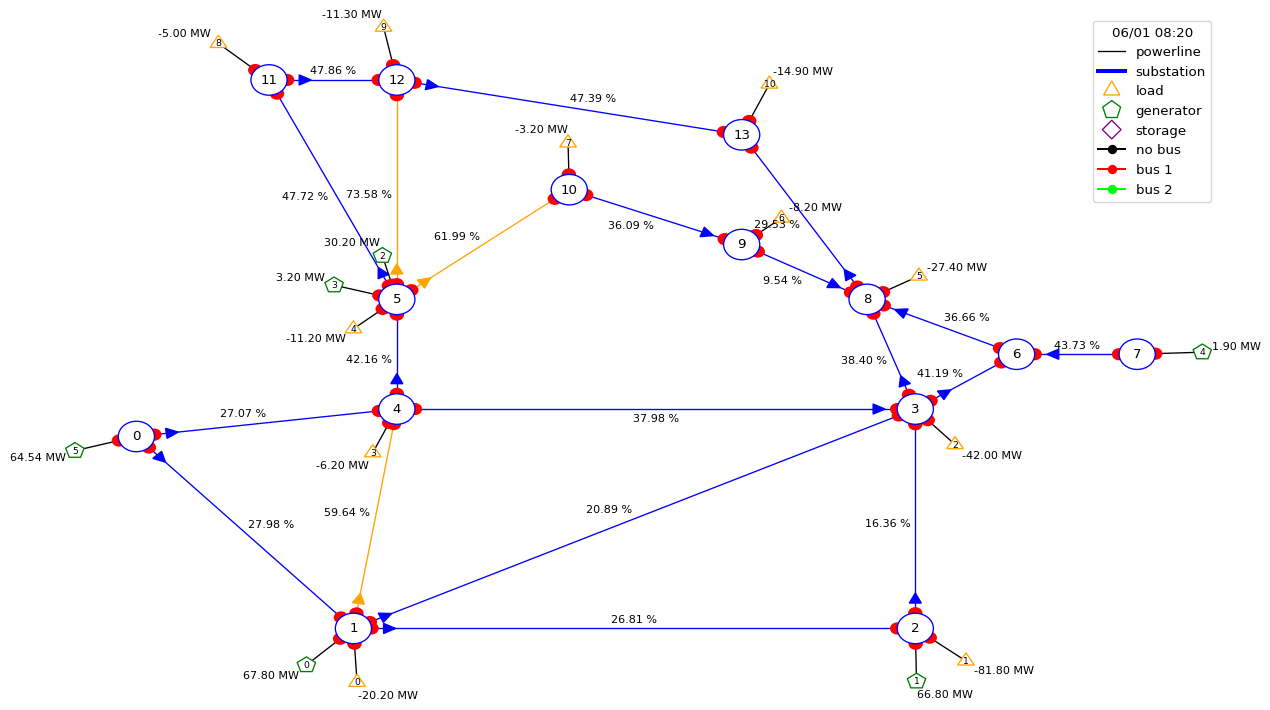

In [93]:
from stable_baselines3 import DQN

def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()



Evaluation Environment

In [94]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    return episode_rewards

Run  the Evaluation

In [95]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Train the model
    #model.learn(total_timesteps=10000)
    #model.save("dqn_grid2op_agent")
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 20
    rewards = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = 265.6854808330536
Episode 2: Total Reward = 1013.5794709920883
Episode 3: Total Reward = 0.05397897958755493
Episode 4: Total Reward = 278.5637264251709
Episode 5: Total Reward = 177.20682415366173
Episode 6: Total Reward = 403.505764529109
Episode 7: Total Reward = 406.60875073075294
Episode 8: Total Reward = 164.51983246207237
Episode 9: Total Reward = 945.4613090008497
Episode 10: Total Reward = 173.80920785665512
Episode 11: Total Reward = 923.342667400837
Episode 12: Total Reward = 316.1493624448776
Episode 13: Total Reward = 353.4813753515482
Episode 14: Total Reward = 357.2664393931627
Episode 15: Total Reward = 273.8815416544676
Episode 16: Total Reward = 462.0795342475176
Episode 17: Total Reward = 1512.891475468874
Episode 18: Total Reward = 1486.52432179451
Episode 19: Total Rewar

Visualise the results

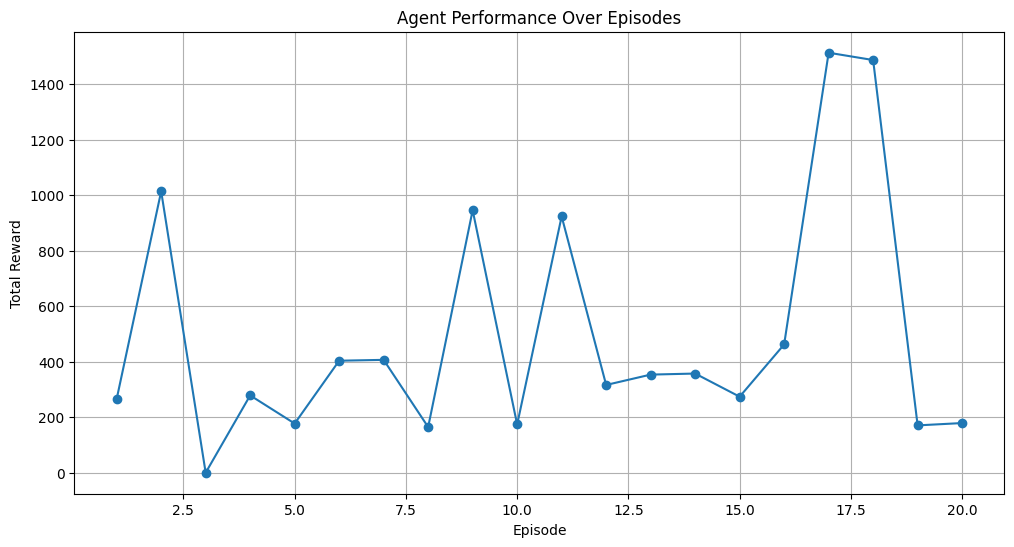

In [96]:
import matplotlib.pyplot as plt

def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

# After evaluation
plot_rewards(rewards)


Extracting individal reward components (L2RPN and N1)

In [97]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_components_list = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        episode_reward_components = {'L2RPN': 0.0, 'N1': 0.0}
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
            # Accumulate reward components
            reward_components = info.get('reward_components', {})
            for key in episode_reward_components.keys():
                episode_reward_components[key] += reward_components.get(key, 0.0)
        episode_rewards.append(total_reward)
        reward_components_list.append(episode_reward_components)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Reward Components: {episode_reward_components}")
        
    return episode_rewards, reward_components_list

Call the evaluate agent function

In [98]:
# Evaluate
rewards, reward_components_list = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

Episode 1: Total Reward = 362.73144848644733
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 2: Total Reward = 350.54281309247017
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 3: Total Reward = 262.8073448240757
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 4: Total Reward = 365.03666196763515
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 5: Total Reward = 359.0655880123377
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 6: Total Reward = 1086.9850522130728
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 7: Total Reward = 183.36027665436268
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 8: Total Reward = 926.4935520291328
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 9: Total Reward = 131.00846144557
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 10: Total Reward = 368.69552816450596
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 11: Total Reward = 1039.355749770999
Reward Components: {'L2RPN': 0.0, 'N1': 0.0}
Episode 12: Tot

Visualising individual reward components

In [106]:
def plot_reward_components(reward_components_list):
    episodes = range(1, len(reward_components_list) + 1)
    l2rpn_rewards = [rc['L2RPN'] for rc in reward_components_list]
    n1_rewards = [rc['N1'] for rc in reward_components_list]
    
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, l2rpn_rewards, label='L2RPN Reward', marker='o')
    plt.plot(episodes, n1_rewards, label='N1 Reward', marker='s')
    plt.title('Reward Components Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

Call the Plot function

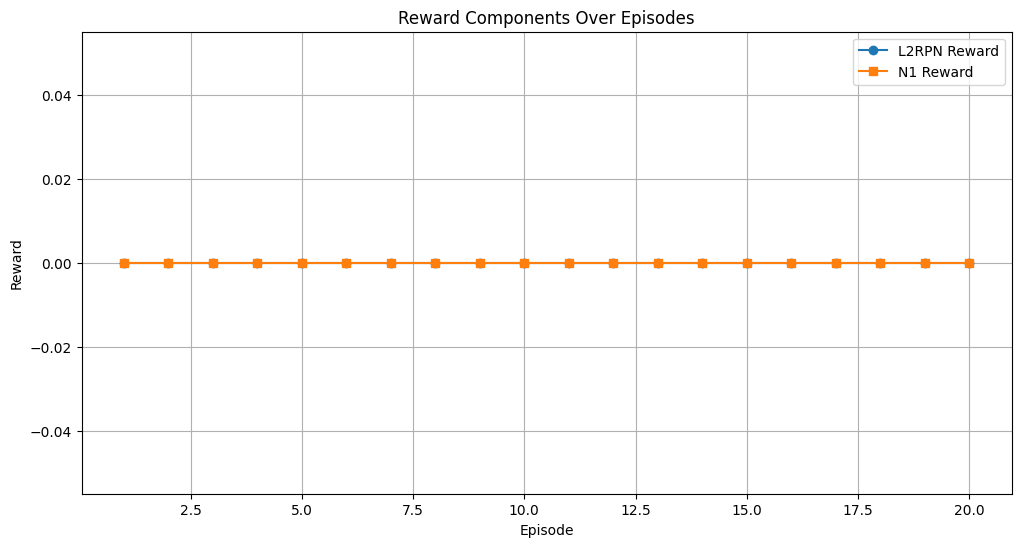

In [107]:
# Plot
plot_reward_components(reward_components_list)


In [108]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend

import numpy as np
from gymnasium.spaces import Box, Discrete, MultiDiscrete, Dict

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward()

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make Grid2Op environment
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        # Combined reward of N1 and L2RPN to evaluate agents
        cr = CombinedScaledReward()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.set_reward(cr)

        # Wrap with gym_compat
        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        # Setup observation and action spaces
        self.setup_observations()
        self.setup_actions()


In [109]:

def setup_observations(self):
        # Flatten the observation space
        original_obs_space = self._gym_env.observation_space

        # Calculate total size of the flattened observation
        self.observation_size = 0
        for space in original_obs_space.spaces.values():
            self.observation_size += int(np.prod(space.shape))

        # Define the new observation space
        low = -np.inf * np.ones(self.observation_size, dtype=np.float32)
        high = np.inf * np.ones(self.observation_size, dtype=np.float32)
        self.observation_space = Box(low=low, high=high, dtype=np.float32)


In [110]:
def setup_actions(self):
        self.available_actions = []

        # Define actions as per the action space of gym_compat
        # 'No operation' action
        self.available_actions.append(0)  # Assuming 0 represents 'no operation'

        # Define additional actions
        # Action 1: Open line 0
        # Action 2: Close line 0
        self.available_actions.append(1)
        self.available_actions.append(2)

        # Define the action space as Discrete
        self.action_space = Discrete(len(self.available_actions))


In [111]:
def step(self, action):
        # Map the discrete action index to the actual action expected by the environment
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components

        return obs, reward, terminated, truncated, info


In [112]:
def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs


In [117]:
def setup_actions(self):
        self.available_actions = []

        # Use the environment's action space to define valid actions
        # For demonstration, we'll assume the environment expects actions as dictionaries

        # Action 0: No operation
        self.available_actions.append({})  # Empty dict represents 'no operation'

        # Action 1: Open line 0
        self.available_actions.append({"set_line_status": [(0, -1)]})

        # Action 2: Close line 0
        self.available_actions.append({"set_line_status": [(0, 1)]})

        # Update the action space to Discrete
        self.action_space = Discrete(len(self.available_actions))

def step(self, action):
        # Map the action index to the actual action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components

        return obs, reward, terminated, truncated, info


In [119]:
def main():
    env = Gym2OpEnv()

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)

    for _ in range(10):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()


In [121]:
from stable_baselines3 import DQN

def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        if terminated or truncated:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()


AttributeError: 'Environment_l2rpn_case14_sandbox' object has no attribute 'set_reward'

In [120]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

AttributeError: 'Environment_l2rpn_case14_sandbox' object has no attribute 'set_reward'

In [21]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Gym2OpEnv from previous code

def train_dqn_agent():
    # Create the environment (vectorized for parallelism if needed)
    env = make_vec_env(lambda: Gym2OpEnv(), n_envs=1)

    # Create the DQN model
    model = DQN("MlpPolicy", env, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Save the model
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step+1))
            break

if __name__ == "__main__":
    train_dqn_agent()


AssertionError: Dict space must have ordered subspaces